<a href="https://colab.research.google.com/github/IFuentesSR/SAMSARA_UAI/blob/main/npphen_deforestation_ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize(project='xxx') # need to initialize with credentials

In [2]:
!pip install KDEpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.4/553.4 kB 2.3 MB/s eta 0:00:00


## Importing required libraries

In [3]:
# Folium setup.
import folium
import sys
import re
import datetime
import numpy as np
import pandas as pd
import time
from multiprocessing import Pool
import itertools
from datetime import datetime
from KDEpy import FFTKDE
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy import interpolate, stats
import plotly.express as px
from sklearn.cluster import KMeans
from skimage import filters
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print(folium.__version__)

0.14.0


## Preprocessing functions Landsat

In [4]:
def mask(img):
    qua = ee.Image(img).select('QA_PIXEL')
    props = img.propertyNames()
    dilated = qua.bitwiseAnd(2).eq(0)
    cirrus = qua.bitwiseAnd(4).eq(0)
    clouds = qua.bitwiseAnd(8).eq(0)
    shadows = qua.bitwiseAnd(16).eq(0)
    snow = qua.bitwiseAnd(32).eq(0)
    return img.updateMask(dilated).updateMask(cirrus).updateMask(clouds).updateMask(shadows).updateMask(snow).multiply(0.0000275).add(-0.2).copyProperties(img, props)


def ndvil8(img):
    props = img.propertyNames()
    ix = img.normalizedDifference(['SR_B5', 'SR_B4'])
    return img.addBands(ix.rename('ndvi')).copyProperties(img, props)


def ndvil57(img):
    props = img.propertyNames()
    ix = img.normalizedDifference(['SR_B4', 'SR_B3'])
    return img.addBands(ix.rename('ndvi')).copyProperties(img, props)

In [5]:
def get_date(x):
    return ee.Date(x).format('YYYY-MM-dd')


def mosaicking(collection):
    def inner(date):
        coll = collection.select('ndvi').filterDate(ee.Date(date), ee.Date(date).advance(1, 'day'))
        img = ee.Image(coll.first())
        props = img.propertyNames()
        return ee.Image(-999).where(coll.mosaic().gte(-1), coll.mosaic())
    return inner


def set_id(fea):
    return fea.set('id', fea.id())


def resample(target):
    def inner(img):
        return img.reproject(ee.Image(target).select('ndvi').projection())
    return inner

In [6]:
def sample(geo):
    def inner(img):
        date = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')
        ndvi = img.reduceRegion('mean', geo.geometry(), scale=30).values().get(0)
        return ee.Feature(None, {'date':date, 'ndvi':ndvi})
    return inner

## npphen Functions

In [7]:
def matched_indices(x, y, masked=False):
    # Flattened x
    x_flat = x.ravel()

    # Indices to sort y
    y_argsort = y.argsort()

    # Indices in sorted y of corresponding x elements, flat
    x_in_y_sort_flat = y.searchsorted(x_flat, sorter=y_argsort)

    # Indices in y of corresponding x elements, flat
    x_in_y_flat = y_argsort[x_in_y_sort_flat]

    if not masked:
        # Reshape to shape of x
        return x_in_y_flat.reshape(x.shape)

    else:
        # Check for inequality at each y index to mask invalid indices
        mask = x_flat != y[x_in_y_flat]
        # Reshape to shape of x
        return np.ma.array(x_in_y_flat.reshape(x.shape), mask=mask.reshape(x.shape))


def calc_kernel(kernel, sample):
    return kernel(sample)


def Phen(array, dates, nGS, rge=[0, 1], h=2, plot=False, dask='multiprocessing'):
    # print(array.shape, len(dates))
    # nGS = np.arange(1, 366, round(365/22))
    # print(array.shape)
    # dates = array.time.values
    if (len(rge)!=2):
        sys.exit("rge must be a vector of maximum 2")
    if (rge[0] > rge[1]):
        sys.exit("rge vector order must be minimum/maximum")
    if (len(dates) != len(array)):
        sys.exit("N of dates and files do not match")
    if np.isnan(array).all():
        return(np.repeat(np.nan, len(nGS)))

    df = pd.DataFrame(data={'x':dates, 'y':array})
    df['x'] = pd.to_datetime(df['x'], format='%Y-%m-%d')
    df['doy'] = df['x'].dt.dayofyear
    if (len(df)<10) | (len(df.dropna(subset=['y']))) < (0.1 * len(df)):
        return(np.repeat(np.nan, len(nGS)))
    if (h!=1) & (h!=2):
        sys.exit("Invalid h")
    dogs = np.vstack([np.arange(1,366,1),
                      np.array(np.arange(185,366,1).tolist() + np.arange(1,185,1).tolist())])

    if (h==2):
        df['doy'] = df['doy'].apply(lambda x: x + 182 if x < 184 else x - 183)
    xmin = 0
    xmax = 366
    ymin = 0
    ymax = 1
    x, y = np.mgrid[xmin:xmax:365j, ymin:ymax:500j]
    positions = np.vstack([x.ravel(), y.ravel()])
    values = df[['doy', 'y']].dropna(how='any').values.T

    if dask == 'FFT':
        fftkde = FFTKDE(kernel="gaussian", bw=0.5).fit(values.T)
        fft_res = fftkde.evaluate(positions.T)
        f = np.reshape(fft_res.T, x.shape)
    elif dask == 'multiprocessing':
        kernel = stats.gaussian_kde(values, bw_method='silverman')
        #Choose number of cores and split input array.
        cores = 4
        torun = np.array_split(positions, cores, axis=1)
        pool = Pool(processes=cores)
        results = pool.starmap(calc_kernel, zip(itertools.repeat(kernel), torun))
        f = np.reshape(np.concatenate(results).T, x.shape)
    elif dask == 'dask':
        kernel = stats.gaussian_kde(values, bw_method='silverman')
        f = np.reshape(kernel(positions).T, x.shape)

    eval_points = np.linspace(rge[0], rge[1], 500)
    k1con = f/f.sum(axis=1).reshape((f.shape[0], 1))
    maxy = k1con.max(axis=1)
    maxy = np.array([np.median(eval_points[np.where(k1con[n,:] == maxy[n])]) for n in range(k1con.shape[0])])
    first_dogs = df['doy'].argmin()
    last_dogs = first_dogs+len(nGS)-1
    ref = maxy[df.loc[np.arange(first_dogs, last_dogs+1, 1), 'doy'].values]
    if plot:
        fig = plt.figure()
        plt.plot(nGS, ref)
        return ref, fig
    else:
        return ref


def PhenKplot(array, dates, nGS, rge=[0, 1], h=2, ylim=(0, 0.15)):
    if (len(rge)!=2):
        sys.exit("rge must be a vector of maximum 2")
    if (rge[0] > rge[1]):
        sys.exit("rge vector order must be minimum/maximum")
    if (len(dates) != len(array)):
        sys.exit("N of dates and files do not match")
    if np.isnan(array).all():
        return(np.repeat(np.nan, len(nGS)))

    df = pd.DataFrame(data={'x':dates, 'y':array})
    df['x'] = pd.to_datetime(df['x'], format='%Y-%m-%d')
    df['doy'] = df['x'].dt.dayofyear
    if (len(df)<10) | (len(df.dropna(subset=['y']))) < (0.1 * len(df)):
        return(np.repeat(np.nan, len(nGS)))
    if (h!=1) & (h!=2):
        sys.exit("Invalid h")
    dogs = np.vstack([np.arange(1,366,1),
                      np.array(np.arange(185,366,1).tolist() + np.arange(1,185,1).tolist())])

    if (h==2):
        df['doy'] = df['doy'].apply(lambda x: x + 182 if x < 184 else x - 183)
    xmin = 1
    xmax = 365
    ymin = rge[0]
    ymax = rge[1]
    x, y = np.mgrid[xmin:xmax:365j, ymin:ymax:500j]
    positions = np.vstack([x.ravel(), y.ravel()])
    values = df[['doy', 'y']].dropna(how='any').values.T
    kernel = stats.gaussian_kde(values, bw_method='silverman')
    f = np.reshape(kernel(positions).T, x.shape)
    eval_points = np.linspace(rge[0], rge[1], 500)
    k1con = f/f.sum(axis=1).reshape((f.shape[0], 1))
    maxy = k1con.max(axis=1)
    maxy = np.array([np.median(eval_points[np.where(k1con[n,:] == maxy[n])]) for n in range(k1con.shape[0])])
    h2density = k1con/k1con.sum()
    uniqueVals = np.unique(np.sort(h2density.ravel()))[::-1]
    cumprobs = np.cumsum(uniqueVals)
    cumdensity = cumprobs[matched_indices(h2density, uniqueVals)]
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xlim(1, 365)
    ax.set_ylim(ylim)
    cfset = ax.contourf(x, y, cumdensity, cmap='terrain')
    cset = ax.contour(x, y, cumdensity, levels=[0, 0.5, 0.75, 0.9, 0.95], colors='k')
    cline = ax.plot(np.arange(1,366), maxy, linewidth=1.5, color='r')
    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel('Day of the year', fontsize=16)
    ax.set_ylabel('NDVI', fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    # fig.tight_layout()
    return x, y, cumdensity, maxy #fig
    # plt.show()


def PhenAnoma(array, dates, nGS, anop, refp, h=2, rge=[0, 1], plot=False, dask='multiprocessing'):
    if (len(rge)!=2):
        sys.exit("rge must be a vector of maximum 2")
    if (rge[0] > rge[1]):
        sys.exit("rge vector order must be minimum/maximum")
    if (len(dates) != len(array)):
        sys.exit("N of dates and files do not match")
    if np.isnan(array).all():
        return(np.repeat(np.nan, len(dates) - anop[0]))

    ref_min = min(refp)
    ref_max = max(refp)
    ano_min = min(anop)
    ano_max = max(anop)
    ano_len = ano_max-ano_min+1

    if (ref_min >= ref_max) | (ano_min >= ano_max):
        sys.exit("for refp or anop, lower value > upper value")

    df = pd.DataFrame(data={'x':dates, 'y':array})
    df['x'] = pd.to_datetime(df['x'], format='%Y-%m-%d')
    df['doy'] = df['x'].dt.dayofyear
    if (len(df)<10) | (len(df.dropna(subset=['y']))) < (0.1 * len(df)):
        return(np.repeat(np.nan, len(dates) - anop[0]))
    if (h!=1) & (h!=2):
        sys.exit("Invalid h")
    dogs = np.vstack([np.arange(1,366,1),
                      np.array(np.arange(185,366,1).tolist() + np.arange(1,185,1).tolist())])

    if (h==2):
        df['doy'] = df['doy'].apply(lambda x: x + 182 if x < 184 else x - 183)

    df1 = df.loc[ref_min:ref_max]
    df2 = df.loc[ano_min:ano_max]

    xmin = 0
    xmax = 366
    ymin = rge[0]
    ymax = rge[1]
    x, y = np.mgrid[xmin:xmax:365j, ymin:ymax:500j]
    positions = np.vstack([x.ravel(), y.ravel()])
    values = df1[['doy', 'y']].dropna(how='any').values.T


    if dask == 'FFT':
        fftkde = FFTKDE(kernel="gaussian", bw=0.5).fit(values.T)
        fft_res = fftkde.evaluate(positions.T)
        f = np.reshape(fft_res.T, x.shape)
    elif dask == 'multiprocessing':
        kernel = stats.gaussian_kde(values, bw_method='silverman')
        #Choose number of cores and split input array.
        cores = 4
        torun = np.array_split(positions, cores, axis=1)
        pool = Pool(processes=cores)
        results = pool.starmap(calc_kernel, zip(itertools.repeat(kernel), torun))
        f = np.reshape(np.concatenate(results).T, x.shape)
    elif dask == 'dask':
        kernel = stats.gaussian_kde(values, bw_method='silverman')
        f = np.reshape(kernel(positions).T, x.shape)

    eval_points = np.linspace(rge[0], rge[1], 500)
    k1con = f/f.sum(axis=1).reshape((f.shape[0], 1))
    maxy = k1con.max(axis=1)
    maxy = np.array([np.median(eval_points[np.where(k1con[n,:] == maxy[n])]) for n in range(k1con.shape[0])])
    anom = df2['y'].values - maxy[df2['doy'].values.astype(int)-1]
    if plot:
        fig = plt.figure()
        plt.plot(df['x'].iloc[ano_min:ano_max], anom[0:ano_len])
        plt.axhline(0, c="red")
        plt.xlabel('Time')
        plt.ylabel('Anomaly')
        return anom, fig
    else:
        return anom

## Break definition from anomalies

In [8]:
def defo_break(array, dates, nGS, ix_anom, h=2, rge=[0,1], plot=False, dask='FFT', ano_number=5):
    anomalies_array = PhenAnoma(array, dates['date'].values, nGS, [ix_anom, len(dates)], [0, ix_anom], h=h, rge=rge, plot=plot, dask=dask)
    std = np.nanstd(array[:ix_anom])
    df = pd.DataFrame(data={'an':anomalies_array,
                            'date':dates.reset_index().iloc[ix_anom: len(dates)]['date'],
                            'ix':dates.reset_index().iloc[ix_anom: len(dates)]['ix']})
    df = df.reset_index()
    df2 = df.copy().dropna(subset=['an'])
    df2['bool'] = [int(n) for n in (np.abs(df2['an']) > 2 * std)]
    df2['cumsum'] = df2.groupby(df2['bool'].eq(0).cumsum()).cumcount().tolist()
    df2 = df2[df2['an'] < 0]

    bks = df2[df2['cumsum'] == ano_number]
    if len(bks) > 0:
        return df.loc[bks.iloc[0].name - 4]['ix'], df.loc[bks.iloc[0].name - 4]['date']
    else:
        return np.nan, pd.to_datetime('1900-01-01')


def defo_breakS2(array, dates, nGS, ix_anom, h=2, rge=[0,1], plot=False, dask='FFT', ano_number=5):
    anomalies_array = PhenAnoma(array, dates['date'].values, nGS, [ix_anom, len(dates)], [0, len(dates)], h=h, rge=rge, plot=plot, dask=dask)
    iqr = np.nanquantile(array, 0.75) - np.nanquantile(array, 0.25)
    df = pd.DataFrame(data={'an':anomalies_array,
                            'date':dates.reset_index().iloc[ix_anom: len(dates)]['date'],
                            'ix':dates.reset_index().iloc[ix_anom: len(dates)]['ix'],
                            'ndvi':array})

    df = df.dropna(subset=['an'])
    df = df.reset_index()
    df['bool'] = [int(n) for n in (np.abs(df['an']) > 1.25 * iqr)]
    df['cumsum'] = df.groupby(df['bool'].eq(0).cumsum()).cumcount().tolist()
    df['diff'] = df['ndvi'].diff(1)
    df['ma'] = df['diff'].rolling(5).mean()
    df2 = df[(df['cumsum'] >= 3) & (df['ma'] < 0)]
    df2 = df2.reset_index()
    if len(df2) > 0:
        if df2.iloc[0]['an'] > iqr:
            idx_mean = df2['ma'].idxmin()
            idx_mean = df2.loc[idx_mean]['level_0']
            return df.loc[idx_mean]['ix'], df.loc[idx_mean]['date']
        else:
            idx_mean = df2.iloc[0]['level_0']
            return df.loc[idx_mean-4]['ix'], df.loc[idx_mean-4]['date']
    else:
        return np.nan, pd.to_datetime('1900-01-01')


In [9]:
import datetime


def get_days(df):
    '''converts breaks to days from 2016-01-01'''
    return lambda x: (df.loc[x]['date']- pd.to_datetime('2016-01-01')).days + 0.0 if x > 0 else np.nan

In [10]:
forested = ee.FeatureCollection('users/ignaciofuentessanroman/IWF_forests').map(set_id)
deforested = ee.FeatureCollection('users/ignaciofuentessanroman/IWF_deforestation').map(set_id)

ids_forested = forested.aggregate_array('id').distinct().getInfo()
ids_deforested = deforested.aggregate_array('id').distinct().getInfo()

## Testing deforested polygon using Landsat

In [15]:
fea = deforested.filter(ee.Filter.eq('id', '00000000000000000048')).first()

l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(fea.geometry()).map(mask).map(ndvil8)
l9 = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2").filterBounds(fea.geometry()).map(mask).map(ndvil8)

In [16]:
geo = ee.Feature(fea)
id = geo.getMapId()
l8_2016 = l8.filterDate('2016-01-01', '2017-01-01').mean().getMapId({'bands':['SR_B5', 'SR_B4', 'SR_B3'], 'min': 0, 'max': 0.3})
l8_2021 = l9.filterDate('2021-01-01', '2022-01-01').mean().getMapId({'bands':['SR_B5', 'SR_B4', 'SR_B3'], 'min': 0, 'max': 0.3})
centroid = geo.centroid().getInfo()['geometry']['coordinates'][::-1]
map = folium.Map(location=centroid, zoom_start=16)
folium.TileLayer(
    tiles=l8_2016['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='s2_2018',
  ).add_to(map)
folium.TileLayer(
    tiles=l8_2021['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='s2_2021',
  ).add_to(map)
folium.TileLayer(
    tiles=id['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='feature',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [17]:
paths = l8.aggregate_histogram('WRS_PATH').getInfo()
path = [i for i in paths if paths[i]==sorted(paths.values())[-1]][0]
l8 = l8.filter(ee.Filter.eq('WRS_PATH', float(path)))
l9 = l9.filter(ee.Filter.eq('WRS_PATH', float(path)))
l7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2").filterBounds(fea.geometry()).filterDate('2000-01-01', '2023-01-01').filter(ee.Filter.eq('WRS_PATH', float(path))).map(mask).map(ndvil57)
l5 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2").filterBounds(fea.geometry()).filterDate('2000-01-01', '2023-01-01').filter(ee.Filter.eq('WRS_PATH', float(path))).map(mask).map(ndvil57)

landsat = l9.merge(l8).merge(l7).merge(l5).select('ndvi').sort('system:time_start').filterDate('2000-01-01', '2022-06-01')

In [18]:
data = landsat.map(sample(fea)).getInfo()

In [19]:
dates = [pd.to_datetime(n['properties']['date']) for n in data['features']]
ndvi = [n['properties']['ndvi'] if 'ndvi' in n['properties'] else None for n in data['features']]

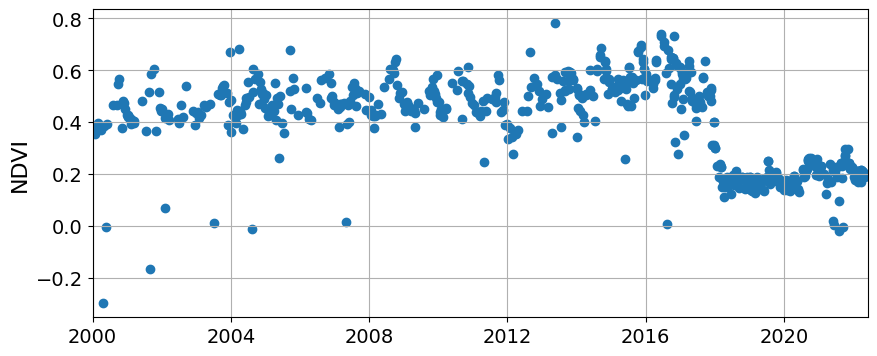

In [20]:
fig = plt.figure(figsize=(10,4))
plt.scatter(dates, ndvi)
plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2022-06-01'))
plt.grid()
plt.ylabel('NDVI', fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.show()

## NPPHEN processing and plots

In [21]:
stack = landsat.toBands().toFloat().sampleRectangle(fea.geometry().bounds().buffer(300), defaultValue=-99.).getInfo()

In [22]:
imgs = [n for n in stack['properties']]
dates_imgs = [pd.to_datetime(re.findall('\d{8}', n)[0], format='%Y%m%d') for n in imgs]
df_dates = pd.DataFrame(data={'date':dates_imgs, 'ix':range(len(dates_imgs))})
df_dates = df_dates.sort_values('date')
ix_anom = df_dates.reset_index()[df_dates.reset_index()['date'] > '2016-01-01'].index[0]
reorder_ix = df_dates['ix'].values
reorder_imgs = [imgs[n] for n in reorder_ix]
stacked = np.stack([stack['properties'][n] for n in reorder_imgs])
stacked[stacked < 0] = np.nan

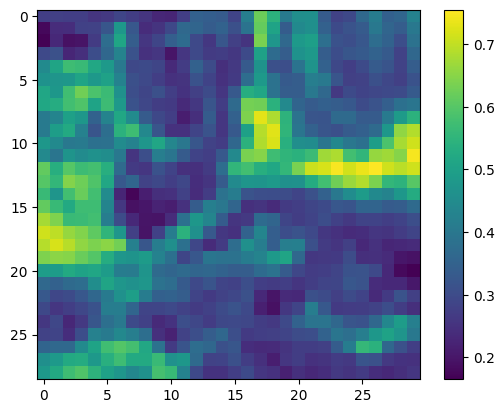

In [23]:
plt.imshow(stacked[1, :, :])
plt.colorbar()

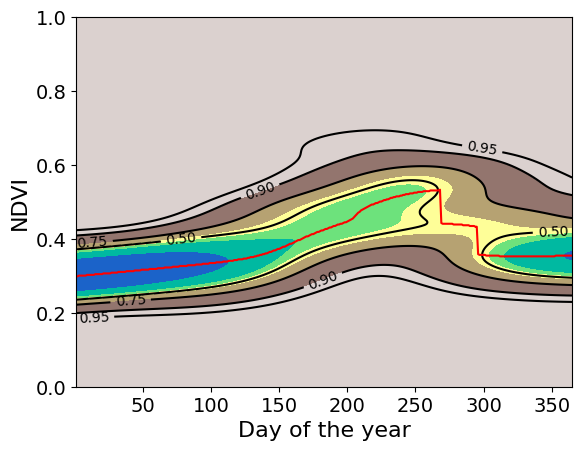

In [32]:
PhenKplot(stacked[:, 20, 20], df_dates['date'].values, np.arange(1, 366, round(365/48)), ylim=(0, 1), h=1)
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/lib/shape_base.py:495: RuntimeWarning: Mean of empty slice
  res = func(*args)


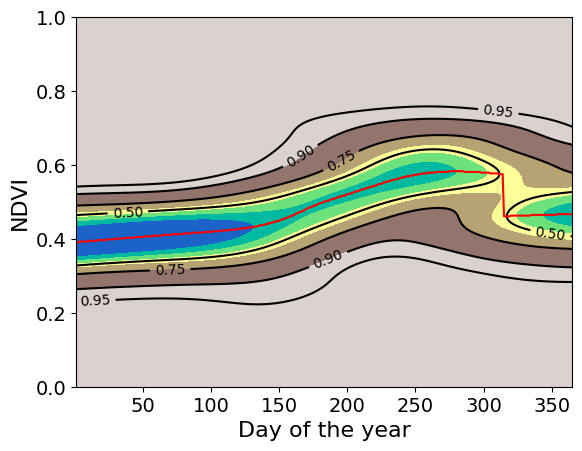

In [31]:
fig = PhenKplot(np.apply_over_axes(np.nanmean, stacked, (1, 2)).ravel(), df_dates['date'].values, np.arange(1, 366, round(365/48)), ylim=(0, 1), h=1)
plt.show()

## NPPHEN anomalies

/usr/local/lib/python3.10/dist-packages/numpy/lib/shape_base.py:495: RuntimeWarning: Mean of empty slice
  res = func(*args)


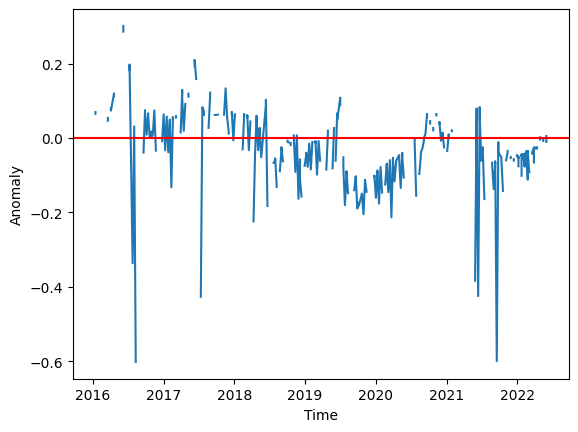

In [26]:
ix_anom = df_dates.reset_index()[df_dates.reset_index()['date'] > '2016-01-01'].index[0]
std_all = np.nanstd(stacked[:ix_anom, :, :])
anom_mean = PhenAnoma(np.apply_over_axes(np.nanmean, stacked, (1, 2)).ravel(),
                        df_dates['date'].values,
                        np.arange(1, 366, round(365/48)),
                        [ix_anom, len(df_dates)],
                        [0, ix_anom], h=2,
                        rge=[0, 1],
                        plot=True,
                        dask='multiprocessing')[0]

## NPPHEN breaks

In [27]:
stacked[stacked == 0] = 0.001
breaks, break_dates = np.apply_along_axis(defo_break,
                                          0,
                                          stacked,
                                          df_dates,
                                          np.arange(1, 366, round(365/48)),
                                          ix_anom,
                                          h=2,
                                          rge=[0, 1],
                                          plot=False,
                                          dask='FFT')

In [28]:
df_dates_anom = df_dates.reset_index().iloc[ix_anom:].set_index('ix')
vfunc = np.vectorize(get_days(df_dates_anom))
days = vfunc(breaks)

values = np.sort(np.unique(days))[:-1]
values = np.linspace(np.min(values), np.max(values), 4)
dates = [pd.to_datetime('2016-01-01') + datetime.timedelta(n) for n in values]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


In [29]:
coords = np.array(fea.geometry().bounds().buffer(300).coordinates().getInfo())[0, :, :]
longs = coords[:, 0]
lats = coords[:, 1]

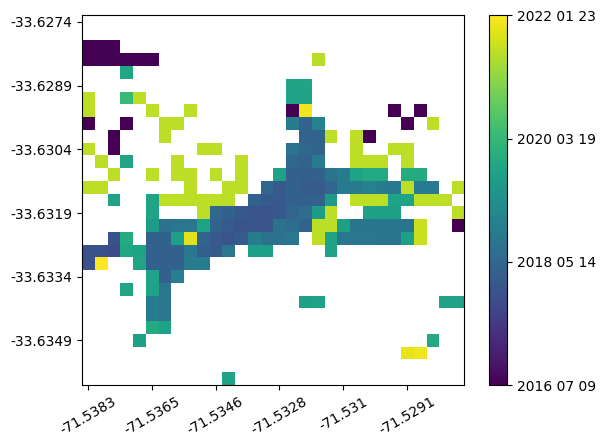

In [30]:
fig, ax = plt.subplots()
f1 = ax.imshow(days, vmin=np.nanmin(days), vmax=np.nanmax(days))
cb = fig.colorbar(f1, ticks=values)
cb.ax.set_yticklabels([n.strftime('%Y %m %d') for n in dates])
plt.xticks([0, 5, 10, 15, 20, 25], labels=np.round(np.linspace(np.min(longs), np.max(longs), 6), 4))
plt.yticks([0, 5, 10, 15, 20, 25], labels=np.round(np.linspace(np.max(lats), np.min(lats), 6), 4))
plt.tick_params(axis='x', rotation=30)
plt.show()
